# **Linear Ordering Problem (LOP)**
### Search heuristics - KISA 2022
### *Naroa Mendez Olarra & Unai Sainz de la Maza Gamboa*


## Part1: Description and Objective function

#### Problem Description
The problem we are solving is called Linear Ordering Problem. In this problem, we are given a matrix $B = [b_{ij}]_{i,j=1,...,n}$ of non-negative numbers. The objective in this problem is to find the joint permutation $\sigma = (\sigma(1)\sigma(2)...\sigma(n))$ of rows and columns that maximises the sum of the numbers above the main diagonal of the matrix.

#### Data
The data given to solve the problem is a matrix $B = [b_{ij}]_{i,j=1,...,n}$ of non-negative numbers, where 
$n$ is equal to the number of rows and columns of the matrix.

#### Possible solution
A permutation $\sigma = (\sigma(1)\sigma(2)...\sigma(n))$ would be a possible solution of the problem.

#### Search space
The search space is all the possible different permutations of size $n$. The size of this search space is $\Omega = n!$

#### Objective function
Given a permutation, the objective function is written as follows:  $f(\sigma)=\sum_{i=1}^{n-1}\sum_{j=i+1}^n b_{\sigma(i)\sigma(j)}$

#### Table of Contents
TODO!
First of all, we have written a function that reads an instance of the LOP problem. Then, we have implemented the objective function and another function that calculates the fitness value of a neighbour. Finally, we have written some example cases.

In [ ]:
# Install the dependencies
#!pip install -r requirements.txt

In [1]:
# Import the dependencies
import numpy as np
import random
import matplotlib.pyplot as plt
import more_itertools as mit
from time import time
import seaborn as sns; sns.set()
import pandas as pd
import random
import time as tm
import pathlib as pl
import math


In [2]:
# Define the path to the instances
instances_path = 'Instances'
std_instances_path = f'{instances_path}/std'
big_instances_path = f'{instances_path}/big'

In [3]:
def read_instance_LOP(filepath):
    """
    Read the instance file and return the size of the problem and the matrix B
    """
    # TODO: rewrite using with(open(filepath)) as fp and try-catch?
    fp = open(filepath)
    line = fp.readline()
    values = line.split()
    size = int(values[0])
    B = np.zeros((size, size))
    for i in range(size):
        line = fp.readline()
        values = line.split()
        for j in range(size):
            B[i][j] = int(values[j])
    fp.close()
    return (size, B)

In [4]:
def obj_func_LOP(solution, instance):
    """
    Calculate the objective function of the solution, where the
    complexity of this (naive) approach is O(n^2)
    """
    size = instance[0]
    B = instance[1]
    value = 0

    for i in range(size - 1):
        for j in range(i + 1, size):
            value += B[solution[i], solution[j]]

    return value


def swap_ngb_obj_func_LOP(instance, solution, prev_fitness, i, j):
    """
    Calculate the swap neighborhood objective function of the solution,
    we use prev_fitness to avoid recalculate the objective function.
    """
    B = instance[1]
    value = prev_fitness

    if j < i:
        i, j = j, i

    # O(n)
    for k in range(i + 1, j):  # [i+1, j) -- j is not included
        # horizontal part
        value -= B[solution[i], solution[k]]  # Remove extracted values
        value += B[solution[j], solution[k]]  # Sum added values (symmetric part)

        # vertical part
        value -= B[solution[k], solution[j]]  # Remove extracted values
        value += B[solution[k], solution[i]]  # Sum added values (symmetric part)

    # If i and j are adjacent values, we skip the for loop, in this case the
    # complexity will be O(1)
    # Last value, where intersects the vertical and horizontal lines
    value -= B[solution[i], solution[j]]  # Remove extracted values
    value += B[solution[j], solution[i]]  # Sum added values (symmetric part)

    return value

In [5]:
instance = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n20.4")

solution = [
    i for i in range(instance[0])
]  # row == column

# Evaluate the solutions
result = obj_func_LOP(solution, instance)
print(f"Objective value of the solution is {result}")

Objective value of the solution is 30369.0


In [6]:
size = instance[0]
result2 = swap_ngb_obj_func_LOP(instance, solution, result, 0, 1)
result22 = swap_ngb_obj_func_LOP(instance, solution, result, size - 2, size - 1)
result23 = swap_ngb_obj_func_LOP(instance, solution, result, 0, size - 1)
print(f'original: {result}')
print(f'swap(0, 1): {result2}')
print(f'swap(last-2, last-1): {result22}')
print(f'swap(0, last-1): {result23}')


original: 30369.0
swap(0, 1): 30372.0
swap(last-2, last-1): 30374.0
swap(0, last-1): 28634.0


In [7]:
def random_search(instance, max_evals):
    """
    Random search algorithm for the LOP with max_evals evaluations
    """
    size = instance[0]
    best_solution = list(mit.random_permutation(range(size)))
    best_fitness = obj_func_LOP(best_solution, instance)
    max_evals -= 1
    
    while max_evals > 0:
        new_sol = list(mit.random_permutation(range(size)))
        new_fit = obj_func_LOP(new_sol, instance)
        if new_fit > best_fitness:
            best_solution = new_sol
            best_fitness = new_fit
        max_evals -= 1
    
    return (best_fitness, best_solution, max_evals)

In [8]:
best_fitness, best_solution, evals = random_search(instance, max_evals=1e5)
print(f'Best solution (permutation): {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Number of evaluations used: {1e5 - evals}')

Best solution (permutation): [7, 2, 18, 16, 3, 17, 10, 19, 6, 0, 13, 4, 11, 15, 14, 1, 5, 8, 9, 12]
Best fitness: 48355.0
Number of evaluations used: 100000.0


## Part 2: Local Search

In [9]:
def constructive_initial_sol(instance, k=3):
    """
    Generate a constructive initial solution for the LOP problem.
    """
    size = instance[0]
    B = instance[1]
    val_index = [(np.sum(B[i, :]) / np.sum(B[:, i])) for i in range(size)]
    solution = []
    sort_i = np.argsort(-1 * np.array(val_index)).tolist()  # * -1 for descending order
    while len(sort_i) > 0:
        options = sort_i[: (min(k, len(sort_i)))]
        total_value = np.sum(
            [val_index[options[kk]] for kk in range(min(k, len(sort_i)))]
        )
        indexes = []
        indexes.append(val_index[options[0]] / total_value)
        for kk in range(1, (min(k, len(sort_i)))):
            indexes.append((val_index[options[kk]] / total_value) + indexes[kk - 1])
        random_number = random.random()
        for kk in range(min(k, len(sort_i))):
            if random_number < indexes[kk]:
                solution.append(options[kk])
                sort_i.pop(kk)
                break

    return solution

In [10]:
def swap(solution, i, j):
    """
    Neighbourhood: Swap the rows and columns of the solution with indices i and j
    """
    solution[i], solution[j] = solution[j], solution[i]
    return solution


def local_search(instance, evals, constructive_solution=True):
    """
    Local search algorithm for the LOP with evals evaluations,
    and a constructive initial solution if constructive_solution is True.
    """
    size = instance[0]
    best_solution = (
        constructive_initial_sol(instance, k=3)
        if constructive_solution
        else list(mit.random_permutation(range(size)))
    )

    best_fitness = obj_func_LOP(best_solution, instance)
    evals -= 1

    while evals > 0:
        improvement = False
        for i in range(size):
            for j in range(i + 1, size):
                new_fitness = swap_ngb_obj_func_LOP(
                    instance, best_solution, best_fitness, i, j
                )
                evals -= 1
                if new_fitness > best_fitness:
                    best_solution = swap(best_solution, i, j)
                    best_fitness = new_fitness
                    improvement = True
                    break  # best first
                else:
                    if evals <= 0:
                        break
            if improvement:
                break
        if not improvement:  # local optimum 
            break
    return (best_fitness, best_solution, evals)

In [11]:
(fitness, sol, evals) = local_search(instance, evals=1e5, constructive_solution=True)
print(f"- fitness: {fitness}\n- solution: {sol}\n- evals used: {1e5 - evals}")

- fitness: 50110.0
- solution: [7, 1, 3, 18, 16, 6, 9, 10, 11, 8, 17, 4, 2, 19, 0, 13, 14, 12, 5, 15]
- evals used: 3014.0


In [17]:
time_list = []
fit_l = []
for i in range(20):
    # random initial solution and 1e5 evaluations
    start = time()
    (fitness, sol, evals) = local_search(
        instance, evals=1e5, constructive_solution=False
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	49801.900  ±  531.445
Time (μ ± σ):	0.021701  ±  0.005281


## Part3: Simulated Annealing

In [18]:
def simulated_annealing(
    instance,
    evals,
    constructive_solution=True,
    initial_temperature=1000,
    temperature_cooling=0.9,
    max_chain=100,
):
    size = instance[0]
    
    # Same as in local search
    best_solution = (
        constructive_initial_sol(instance, k=3)
        if constructive_solution
        else list(mit.random_permutation(range(size)))
    )

    best_fitness = obj_func_LOP(best_solution, instance)
    evals -= 1
    T = initial_temperature

    while T > 0.1 and evals > 0:  # stop condition
        chain_size = 0
        while chain_size < max_chain and evals > 0:  # equilibrium
            i, j = random.randint(0, size - 1), random.randint(0, size - 1)
            if i == j:
                if i != size - 1:
                    j += 1
                else:
                    i -= 1
            new_fitness = swap_ngb_obj_func_LOP(
                instance, best_solution, best_fitness, i, j
            )
            deltaE = new_fitness - best_fitness
            if deltaE > 0:
                best_solution = swap(best_solution, i, j)
                best_fitness = new_fitness
            else:
                probability = math.exp(deltaE / T)
                if probability > random.random():
                    best_solution = swap(best_solution, i, j)
                    best_fitness = new_fitness
            chain_size += 1
            evals -= 1
        T = T * temperature_cooling  # Geometric schedule
    return (best_fitness, best_solution, evals)

In [19]:
time_list = []
fit_l = []
for i in range(10):
    start = time()
    (fitness, sol, evals) = simulated_annealing(
        instance, evals=10000, constructive_solution=False
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	50392.400  ±  169.283
Time (μ ± σ):	0.055866  ±  0.001931


## Part 4: Genetic algorithm

In [20]:
def genetic_algorithm(
    instance, evals, population_size=100, mutation_prob=0.1, max_patience=10
):
    def get_roulette(F):
        roulette = []  # range [0-1] values, ordered
        last_val = 0
        npF = np.asarray(F)
        sumF = np.sum(npF)

        for f in npF:
            last_val = last_val + f / sumF
            roulette.append(last_val)
        return roulette

    def find_near_val_index(lista, value):
        for i, v in enumerate(lista):
            if value <= v:
                return i

    def select(roulette):
        # roulette selection
        pos = []
        for _ in ["mom", "dad"]:
            r = random.random()
            ind = find_near_val_index(roulette, r)
            pos.append(ind)

        return pos[0], pos[1]

    def mutation(indiv):
        # swap random i and j
        i, j = random.randint(0, size - 1), random.randint(0, size - 1)
        if i == j:
            if i != size - 1:
                j += 1
            else:
                i -= 1
        indiv = swap(indiv, i, j)
        return indiv

    # Order crossover
    def reproduce(P, mom, dad):
        index1 = random.randint(0, size - 1)
        index2 = random.randint(index1, size)

        marked_out1 = P[mom][index1:index2]  # naranja
        marked_out2 = P[dad][index1:index2]

        rest_1 = [x for x in P[mom] if x not in set(marked_out2)]
        rest_2 = [x for x in P[dad] if x not in set(marked_out1)]  # azul

        son1 = rest_1[:index1] + marked_out2 + rest_1[index1:]
        son2 = rest_2[:index1] + marked_out1 + rest_2[index1:]  # child1

        # mutation
        if random.random() <= mutation_prob:
            son1 = mutation(son1)
        if random.random() <= mutation_prob:
            son2 = mutation(son2)
        return son1, son2

    def evaluate(P, instance, evals):
        F = []  # actual fitness of each individual
        if evals > population_size:
            for act in range(population_size):
                v = obj_func_LOP(P[act], instance)
                F.append(v)
            evals -= population_size
        else:
            for act in range(evals):
                v = obj_func_LOP(P[act], instance)
                F.append(v)
            evals = 0
        return F, evals

    size = instance[0]
    patience = 0
    best_fitness = 0
    P = []  # actual population
    F = []  # actual fitness of each individual
    odd_population = population_size % 2 == 1

    # First generation
    for _ in range(population_size):
        sol = list(mit.random_permutation(range(size)))
        P.append(sol)
    
    F, evals = evaluate(P, instance, evals)
    while patience < max_patience and evals > 0:  # stop_criterion
        sons = []
        roulette = get_roulette(F)
        for i in range(population_size // 2):
            mom_i, dad_i = select(roulette)
            son1, son2 = reproduce(P, mom_i, dad_i)
            sons = sons + [son1, son2]
        if odd_population:
            mom_i, dad_i = select(P, roulette)
            son1, _ = reproduce(P, mom_i, dad_i)
            sons = sons + [son1]

        sons[0] = P[
            F.index(max(F))
        ]  # substitute first son with the previous generation best individual, elitism
        P = sons
        F, evals = evaluate(P, instance, evals)
        if max(F) > best_fitness:
            best_fitness = max(F)
            patience = 0
        else:
            patience += 1

    i = F.index(max(F))
    best_solution = P[i]
    best_fitness = F[i]

    return (best_fitness, best_solution, evals)

In [26]:
(fitness, sol, evals) = genetic_algorithm(
    instance, evals=10000, population_size=10, mutation_prob=0.1, max_patience=10
)
print(f"- fitness: {fitness}\n- solution: {sol}\n- evals used: {10000 - evals}")

- fitness: 45822.0
- solution: [7, 3, 16, 2, 13, 14, 1, 8, 10, 0, 19, 12, 18, 11, 9, 5, 17, 6, 15, 4]
- evals used: 200


In [23]:
time_list = []
fit_l = []
for i in range(10):
    start = time()
    (fitness, sol, evals) = genetic_algorithm(
        instance, evals=10000, population_size=10, mutation_prob=0.1, max_patience=10
    )
    end = time()
    time_list.append(end - start)
    fit_l.append(fitness)
print(
    "Fitness(μ ± σ):\t{:.3f}  ±  {:.3f}".format(
        float(np.mean(fit_l)), float(np.std(fit_l))
    )
)
print(
    "Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(
        float(np.mean(time_list)), float(np.std(time_list))
    )
)

Fitness(μ ± σ):	45620.300  ±  2294.354
Time (μ ± σ):	0.017367  ±  0.011118


## Part 5: experimentation

### Parameter Tuning Process

In [27]:
instance_10 = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n10.1")
instance_30 = read_instance_LOP(f"{std_instances_path}/Cebe.lop.n30.3")

In [39]:
N_RUNS = 10

#### Simulated Annealing

In [ ]:
max_evals = 50000
initial_temperatures = [100, 500, 1500, 2500]
temperature_cooling = [0.75, 0.9, 0.95]
max_chain = [50, 100, 500, 750]

In [35]:
print("Initial temperature \t Cooling \t max_chain \t Fitness(μ ± σ) \t evals")
avg_fitnesses = []
deviations = []
list_initial_temperatures = []
list_coolings = []
list_max_chain = []

for tmp in initial_temperatures:
    for cooling in temperature_cooling:
        for chain in max_chain:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = simulated_annealing(
                    instance_10,
                    evals=max_evals,
                    constructive_solution=False,
                    initial_temperature=tmp,
                    temperature_cooling=cooling,
                    max_chain=chain,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
                # print(fitness, sol)
            list_initial_temperatures.append(tmp)
            list_coolings.append(cooling)
            list_max_chain.append(chain)
            avg_fitnesses.append(np.mean(fit_l))
            deviations.append(np.std(fit_l))
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.3f}  ±  {:.3f} \t {:^6}".format(
                    tmp,
                    cooling,
                    chain,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )
            # print("Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(float(np.mean(time_list)), float(np.std(time_list))))


Initial temperature 	 Cooling 	 max_chain 	 Fitness(μ ± σ) 	 evals
        100          	   0.75   	     50     	2375.300  ±  15.317 	  1251 
        100          	   0.75   	    100     	2369.100  ±  41.375 	  2501 
        100          	   0.75   	    500     	2383.000  ±  0.775 	 12501 
        100          	   0.75   	    750     	2382.900  ±  0.831 	 18751 
        100          	   0.9    	     50     	2377.800  ±  14.945 	  3301 
        100          	   0.9    	    100     	2382.800  ±  0.748 	  6601 
        100          	   0.9    	    500     	2381.400  ±  5.517 	 33001 
        100          	   0.9    	    750     	2383.300  ±  0.458 	 49501 
        100          	   0.95   	     50     	2382.900  ±  0.831 	  6751 
        100          	   0.95   	    100     	2382.500  ±  0.500 	 13501 
        100          	   0.95   	    500     	2380.400  ±  6.829 	 50000 
        100          	   0.95   	    750     	2379.800  ±  2.272 	 50000 
        500          	   0.75   	     50  

    Initial temperature  Cooling  Max_chain  Average fitness  Standard deviation
7                   100     0.90        750           2383.3            0.458258
17                  500     0.90        100           2383.2            0.871780
2                   100     0.75        500           2383.0            0.774597
15                  500     0.75        750           2383.0            0.632456
8                   100     0.95         50           2382.9            0.830662
30                 1500     0.90        500           2382.9            0.700000
3                   100     0.75        750           2382.9            0.830662
14                  500     0.75        500           2382.9            0.943398
27                 1500     0.75        750           2382.9            0.830662
18                  500     0.90        500           2382.8            0.600000
5                   100     0.90        100           2382.8            0.748331
19                  500     

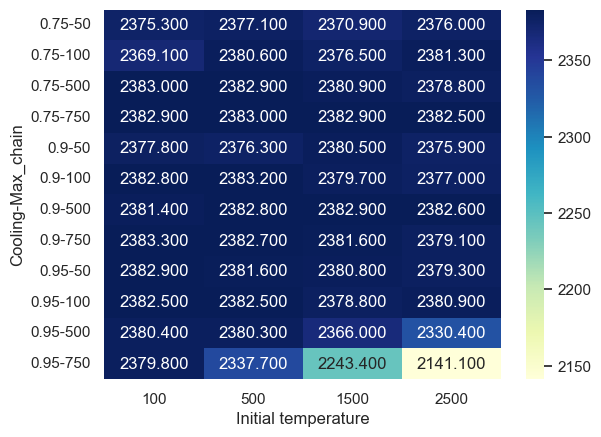

In [38]:
pd.set_option("expand_frame_repr", False)
datos = pd.DataFrame(
    {
        "Initial temperature": list_initial_temperatures,
        "Cooling": list_coolings,
        "Max_chain": list_max_chain,
        "Average fitness": avg_fitnesses,
        "Standard deviation": deviations,
    }
)

datos.sort_values(
    by=["Average fitness"], inplace=True, ascending=False
)
print(datos)

datos = datos.pivot(
    index=["Cooling", "Max_chain"],
    columns=[
        "Initial temperature",
    ],
    values="Average fitness",
)

sns.heatmap(datos, annot=True, fmt=".3f", cmap="YlGnBu")
datos.sort_index(axis=0, ascending=False, inplace=True)
print(datos)

# TODO: change!!!
# BEST: Temperatura init (100), cooling (0.90) y max_chain (750).
# Fitness: 2383.3  ±  0.458

In [31]:
print("Initial temperature \t Cooling \t max_chain \t Fitness(μ ± σ) \t evals")

avg_fitnesses = []
deviations = []
list_initial_temperatures = []
list_coolings = []
list_max_chain = []

for tmp in initial_temperatures:
    for cooling in temperature_cooling:
        for chain in max_chain:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = simulated_annealing(
                    instance_30,
                    evals=max_evals,
                    constructive_solution=False,
                    initial_temperature=tmp,
                    temperature_cooling=cooling,
                    max_chain=chain,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            list_initial_temperatures.append(tmp)
            list_coolings.append(cooling)
            list_max_chain.append(chain)
            avg_fitnesses.append(np.mean(fit_l))
            deviations.append(np.std(fit_l))
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.3f}  ±  {:.3f} \t {:^6}".format(
                    tmp,
                    cooling,
                    chain,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )
            # print("Time (μ ± σ):\t{:.6f}  ±  {:.6f}".format(float(np.mean(time_list)), float(np.std(time_list))))

Initial temperature 	 Cooling 	 max_chain 	 Fitness(μ ± σ) 	 evals
        100          	   0.75   	     50     	58869.700  ±  460.105 	  1251 
        100          	   0.75   	    100     	59295.000  ±  670.566 	  2501 
        100          	   0.75   	    500     	59750.600  ±  407.516 	 12501 
        100          	   0.75   	    750     	60080.300  ±  310.166 	 18751 
        100          	   0.9    	     50     	59183.900  ±  529.485 	  3301 
        100          	   0.9    	    100     	59463.900  ±  415.279 	  6601 
        100          	   0.9    	    500     	59759.300  ±  446.546 	 33001 
        100          	   0.9    	    750     	60165.200  ±  366.757 	 49501 
        100          	   0.95   	     50     	59335.000  ±  535.916 	  6751 
        100          	   0.95   	    100     	59462.400  ±  625.247 	 13501 
        100          	   0.95   	    500     	59960.300  ±  434.475 	 50000 
        100          	   0.95   	    750     	60262.600  ±  343.360 	 50000 
        5

    Initial temperature  Cooling  Max_chain  Average fitness  Standard deviation
43                 2500     0.90        750          60560.1          188.118287
34                 1500     0.95        500          60553.3          207.438208
22                  500     0.95        500          60451.9          190.622900
19                  500     0.90        750          60420.9          200.569913
23                  500     0.95        750          60398.7          266.183790
18                  500     0.90        500          60365.0          212.693206
15                  500     0.75        750          60323.6          272.953916
27                 1500     0.75        750          60308.5          295.891619
46                 2500     0.95        500          60303.6          286.408869
31                 1500     0.90        750          60269.2          313.396171
30                 1500     0.90        500          60267.9          280.935384
11                  100     

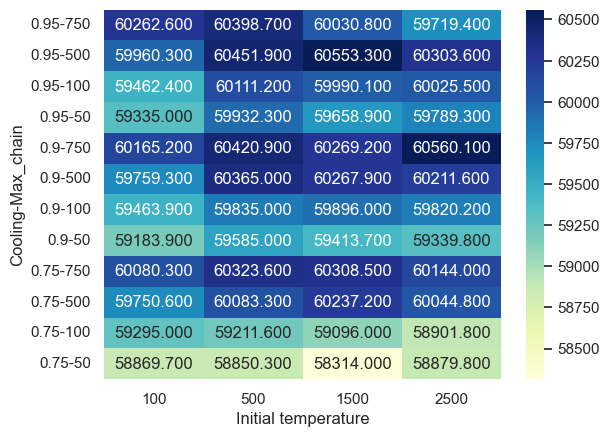

In [33]:
pd.set_option("expand_frame_repr", False)
datos = pd.DataFrame(
    {
        "Initial temperature": list_initial_temperatures,
        "Cooling": list_coolings,
        "Max_chain": list_max_chain,
        "Average fitness": avg_fitnesses,
        "Standard deviation": deviations,
    }
)

datos.sort_values(
    by=["Average fitness"], inplace=True, ascending=False
)
print(datos)

datos = datos.pivot(
    index=["Cooling", "Max_chain"],
    columns=[
        "Initial temperature",
    ],
    values="Average fitness",
)
datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, annot=True, fmt=".3f", cmap="YlGnBu")

print(datos)

# TODO: change!!!
# BEST: Temperatura inicial alta (1500), cooling intermedio (0.9) y max_chain alto (500). Se llega al max de evals.
# Fitness: 50598.300  ±  100.997

#### Genetic Algorithm

In [ ]:
max_evals = 25000
population_size = [10, 100, 500, 1000]
mutation_prob = [0.05, 0.1, 0.3, 0.5]
max_patiences = [1, 10, 20, 30, 50]

In [ ]:
list_populations_size = []
list_mutation_prob = []
list_patiences = []
list_avg_fit = []
list_avg_evals = []
list_avg_time = []

print("Population size \t mutation prob \t patience \t Fitness(μ ± σ) \t evals")
for pop_s in population_size:
    for mut_p in mutation_prob:
        for patience in max_patiences:
            time_list = []
            fit_l = []
            for i in range(20):
                start = time()
                (fitness, sol, evals) = genetic_algorithm(
                    instance,
                    evals=max_evals,
                    population_size=pop_s,
                    mutation_prob=mut_p,
                    max_patience=patience,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.1f}  ±  {:.1f} \t {:>6}".format(
                    pop_s,
                    mut_p,
                    patience,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )

            list_populations_size.append(pop_s)
            list_mutation_prob.append(mut_p)
            list_patiences.append(patience)
            list_avg_fit.append(float(np.mean(fit_l)))
            list_avg_time.append(float(np.mean(time_list)))
            list_avg_evals.append(max_evals - evals)


In [ ]:
datos = pd.DataFrame(
    {
        "Pop_size": list_populations_size,
        "Mutation_prob": list_mutation_prob,
        "Patience": list_patiences,
        "Average fitness": list_avg_fit,
    }
)
datos = datos.pivot(
    index=["Pop_size", "Mutation_prob"],
    columns=[
        "Patience",
    ],
    values="Average fitness",
)
datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, annot=True, fmt=".3f", cmap="YlGnBu")

datos.sort_values(by=['Average fitness'], inplace=True, ascending=False)
print(datos)


In [ ]:
list_populations_size = []
list_mutation_prob = []
list_patiences = []
list_avg_fit = []
list_avg_evals = []
list_avg_time = []

print("Population size \t mutation prob \t patience \t Fitness(μ ± σ) \t evals")
for pop_s in population_size:
    for mut_p in mutation_prob:
        for patience in max_patiences:
            time_list = []
            fit_l = []
            for i in range(N_RUNS):
                start = time()
                (fitness, sol, evals) = genetic_algorithm(
                    instance,
                    evals=max_evals,
                    population_size=pop_s,
                    mutation_prob=mut_p,
                    max_patience=patience,
                )
                end = time()
                time_list.append(end - start)
                fit_l.append(fitness)
            print(
                "{:^20} \t {:^8} \t {:^10} \t{:.1f}  ±  {:.1f} \t {:>6}".format(
                    pop_s,
                    mut_p,
                    patience,
                    float(np.mean(fit_l)),
                    float(np.std(fit_l)),
                    max_evals - evals,
                )
            )

            list_populations_size.append(pop_s)
            list_mutation_prob.append(mut_p)
            list_patiences.append(patience)
            list_avg_fit.append(float(np.mean(fit_l)))
            list_avg_time.append(float(np.mean(time_list)))
            list_avg_evals.append(max_evals - evals)


In [ ]:
datos = pd.DataFrame(
    {
        "Pop_size": list_populations_size,
        "Mutation_prob": list_mutation_prob,
        "Patience": list_patiences,
        "Average fitness": list_avg_fit,
    }
)
datos = datos.pivot(
    index=["Pop_size", "Mutation_prob"],
    columns=[
        "Patience",
    ],
    values="Average fitness",
)

datos.sort_index(axis=0, ascending=False, inplace=True)
sns.heatmap(datos, annot=True, fmt=".3f", cmap="YlGnBu")

datos.sort_values(by=['Average fitness'], inplace=True, ascending=False)
print(datos)


### Execution time

#### Objective function

In [3]:
sizes = [1, 100, 1000, 10000]
time_list_standard = []
time_list_optimized = []

for size in sizes:
    instance = []

    sol = list(mit.random_permutation(range(size)))
    instance.append(size)
    instance.append(np.ones((size,) * 2))

    # Standard
    start = time()
    obj_func_LOP(sol, instance)
    end = time()
    time_list_standard.append(end - start)

    # Optimized objective function for swap neighborhood
    start = time()
    swap_ngb_obj_func_LOP(instance, sol, 50, 0, size - 1)
    end = time()
    time_list_optimized.append(end - start)


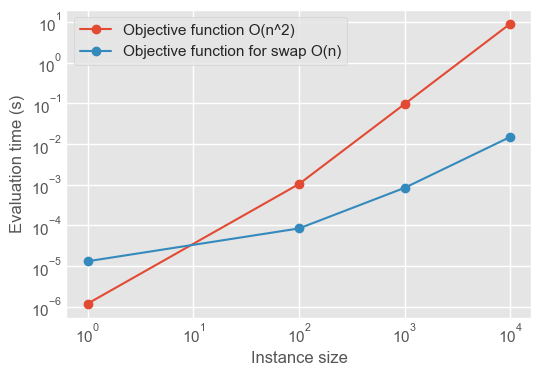

In [24]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(6, 4))
    plt.tick_params(axis='both', which='major', length=0)
    plt.plot(
        sizes,
        time_list_standard, 
        marker="o", 
        label="Objective function O(n^2)"
    )
    plt.plot(
        sizes,
        time_list_optimized,
        marker="o",
        label="Objective function for swap O(n)",
    )
    plt.xlabel("Instance size")
    plt.ylabel("Evaluation time (s)")
    #plt.title("Execution time of the objective functions")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.savefig("time_complexity_obj_func.pdf", bbox_inches="tight")
    plt.show()

### Eval Analisis

In [ ]:
# TODO: change!!!
instance = read_instance_LOP("Instances/Cebe.lop.n20.4")

RS_time_list = []
LS_time_list = []
GA_time_list = []
SA_time_list = []
RS_fit_list = []
LS_fit_list = []
GA_fit_list = []
SA_fit_list = []
evaluations = [10**i for i in range(7)]

for max_evals in evaluations:
    print(max_evals)
    RS_fit_l = []
    LS_fit_l = []
    GA_fit_l = []
    SA_fit_l = []
    RS_time_l = []
    LS_time_l = []
    GA_time_l = []
    SA_time_l = []
    for i in range(30):
        start = time()
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        RS_time_l.append(time() - start)
        RS_fit_l.append(fitness)

        start = time()
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        LS_time_l.append(time() - start)
        LS_fit_l.append(fitness)

        start = time()
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=1500,
            temperature_cooling=0.9,
            max_chain=750,
            constructive_solution=False,
        )
        SA_time_l.append(time() - start)
        SA_fit_l.append(fitness)

        start = time()
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=100,
            mutation_prob=0.05,
            max_patience=50,
        )
        GA_time_l.append(time() - start)
        GA_fit_l.append(fitness)

    RS_time_list.append(float(np.mean(RS_time_l)))
    LS_time_list.append(float(np.mean(LS_time_l)))
    GA_time_list.append(float(np.mean(GA_time_l)))
    SA_time_list.append(float(np.mean(SA_time_l)))
    RS_fit_list.append(float(np.mean(RS_fit_l)))
    LS_fit_list.append(float(np.mean(LS_fit_l)))
    GA_fit_list.append(float(np.mean(GA_fit_l)))
    SA_fit_list.append(float(np.mean(SA_fit_l)))


In [ ]:
plt.figure(figsize=(9, 7))
plt.plot(evaluations, RS_fit_list, marker='o', label="Random Search")
plt.plot(evaluations, LS_fit_list, marker='o', label="Local Search")
plt.plot(evaluations, GA_fit_list, marker='o', label="Genetic Algorithm")
plt.plot(evaluations, SA_fit_list, marker='o', label="Simulated Annealing")
plt.ylabel('Fitness')
plt.xlabel('Max Evaluations')
plt.title("Fitness evolution per maxEval")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9, 7))
plt.plot(evaluations, RS_time_list, marker="o", label="Random Search")
plt.plot(evaluations, LS_time_list, marker="o", label="Local Search")
plt.plot(evaluations, GA_time_list, marker="o", label="Genetic Algorithm")
plt.plot(evaluations, SA_time_list, marker="o", label="Simulated Annealing")
plt.ylabel("Time")
plt.xlabel("Max Evaluations")
plt.title("Time Evolution per maxEval")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


### Benchmarks 
Analisis multiple instancias, multiples repeticiones 
(cuanto más grande, menos repeticiones, debido al coste computacional)

In [ ]:
from glob import glob

files = glob("Instances/*.*")
files.sort()

fit_list_list_random = []
fit_list_list_local = []
fit_list_list_simulated = []
fit_list_list_genetic = []
max_evals = 20000

for f in files:
    print(f)

    instance = read_instance_LOP(f)
    fit_l_random = []
    fit_l_local = []
    fit_l_simulated = []
    fit_l_genetic = []

    for i in range(100):
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        fit_l_random.append(fitness)
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        fit_l_local.append(fitness)
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=1500,
            temperature_cooling=0.9,
            max_chain=750,
            constructive_solution=False,
        )
        fit_l_simulated.append(fitness)
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=100,
            mutation_prob=0.05,
            max_patience=50,
        )
        fit_l_genetic.append(fitness)
    fit_list_list_random.append(fit_l_random)
    fit_list_list_local.append(fit_l_local)
    fit_list_list_simulated.append(fit_l_simulated)
    fit_list_list_genetic.append(fit_l_genetic)


In [ ]:
avgs_random = np.mean(fit_list_list_random, axis=1)
stds_random = np.std(fit_list_list_random, axis=1)

avgs_local = np.mean(fit_list_list_local, axis=1)
stds_local = np.std(fit_list_list_local, axis=1)

avgs_simulated = np.mean(fit_list_list_simulated, axis=1)
stds_simulated = np.std(fit_list_list_simulated, axis=1)

avgs_genetic = np.mean(fit_list_list_genetic, axis=1)
stds_genetic = np.std(fit_list_list_genetic, axis=1)

datos = pd.DataFrame(
    {
        "RS avg": avgs_random,
        "RS std": stds_random,
        "LS avg": avgs_local,
        "LS std": stds_local,
        "GA avg": avgs_simulated,
        "GA std": stds_simulated,
        "SA avg": avgs_genetic,
        "SA std": stds_genetic,
        "Instance": files,
    }
)
datos.sort_values(by=["Instance"], inplace=True, ascending=True)
print(datos)


In [ ]:
try:
    datos.to_csv("Normal_Instance_avg_std.csv")
    df = pd.DataFrame(
        {
            "Random": fit_list_list_random,
            "Local": fit_list_list_local,
            "Simulated": fit_list_list_simulated,
            "Genetic": fit_list_list_genetic,
        }
    )
    df.to_csv("Normal_Instance_Results.csv")
except:
    pass


#### BIG instances

In [ ]:
from glob import glob

big_files = glob("Instances/big/*")
big_files.sort()

# fit_list_list_random = []
# fit_list_list_local = []
# fit_list_list_simulated = []
# fit_list_list_genetic = []
max_evals = 10000

for f in big_files[-2:]:
    print(f)

    instance = read_instance_LOP(f)
    fit_l_random = []
    fit_l_local = []
    fit_l_simulated = []
    fit_l_genetic = []

    for i in range(10):
        (fitness, sol, evals) = random_search(instance, max_evals=max_evals)  # baseline
        fit_l_random.append(fitness)
        (fitness, sol, evals) = local_search(
            instance, evals=max_evals, constructive_solution=False
        )
        fit_l_local.append(fitness)
        (fitness, sol, evals) = simulated_annealing(
            instance,
            evals=max_evals,
            initial_temperature=1500,
            temperature_cooling=0.9,
            max_chain=750,
            constructive_solution=False,
        )
        fit_l_simulated.append(fitness)
        (fitness, sol, evals) = genetic_algorithm(
            instance,
            evals=max_evals,
            population_size=100,
            mutation_prob=0.05,
            max_patience=50,
        )
        fit_l_genetic.append(fitness)
    fit_list_list_random.append(fit_l_random)
    fit_list_list_local.append(fit_l_local)
    fit_list_list_simulated.append(fit_l_simulated)
    fit_list_list_genetic.append(fit_l_genetic)


In [ ]:
avgs_random = np.mean(fit_list_list_random, axis=1)
stds_random = np.std(fit_list_list_random, axis=1)

avgs_local = np.mean(fit_list_list_local, axis=1)
stds_local = np.std(fit_list_list_local, axis=1)

avgs_simulated = np.mean(fit_list_list_simulated, axis=1)
stds_simulated = np.std(fit_list_list_simulated, axis=1)

avgs_genetic = np.mean(fit_list_list_genetic, axis=1)
stds_genetic = np.std(fit_list_list_genetic, axis=1)

datos = pd.DataFrame(
    {
        "RS avg": avgs_random,
        "RS std": stds_random,
        "LS avg": avgs_local,
        "LS std": stds_local,
        "GA avg": avgs_simulated,
        "GA std": stds_simulated,
        "SA avg": avgs_genetic,
        "SA std": stds_genetic,
        "Instance": big_files,
    }
)
datos.sort_values(by=["Instance"], inplace=True, ascending=True)
print(datos)


In [ ]:
try:
    datos.to_csv("Big_Instance_avg_std.csv")
    df = pd.DataFrame(
        {
            "Random": fit_list_list_random,
            "Local": fit_list_list_local,
            "Simulated": fit_list_list_simulated,
            "Genetic": fit_list_list_genetic,
        }
    )
    df.to_csv("Big_Instance_Results.csv")
except:
    pass
